# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

## Data preparation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df_clean = df.replace('?', np.nan)

print("Missing values after cleaning:")
print(df_clean.isnull().sum())

X = df_clean.drop('class', axis=1)
y = df_clean['class']

Missing values after cleaning:
class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


In [10]:
# We need to encode categorical variables before modeling
le = LabelEncoder()

y_encoded = le.fit_transform(y)

print(f"\nTarget encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")



Target encoding: {'e': np.int64(0), 'p': np.int64(1)}


In [13]:
le_dict = {}
X_onehot = pd.get_dummies(X, drop_first=True)

print(f"Original features: {X.shape[1]}")
print(f"One-hot encoded features: {X_onehot.shape[1]}")
print(f"\nDataset shape: {X_onehot.shape}")
print("\nFirst few encoded feature names:")
print(X_onehot.columns[:15].tolist())

X_onehot.head()




Original features: 20
One-hot encoded features: 102

Dataset shape: (61069, 102)

First few encoded feature names:
['cap-diameter', 'stem-height', 'stem-width', 'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p', 'cap-shape_s', 'cap-shape_x', 'cap-surface_e', 'cap-surface_g', 'cap-surface_h', 'cap-surface_i', 'cap-surface_k', 'cap-surface_l']


,cap-diameter,stem-height,stem-width,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_e,cap-surface_g,cap-surface_h,cap-surface_i,cap-surface_k,cap-surface_l,cap-surface_s,cap-surface_t,cap-surface_w,cap-surface_y,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,does-bruise-or-bleed_t,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_p,gill-attachment_s,gill-attachment_x,gill-spacing_d,gill-spacing_f,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-root_c,stem-root_f,stem-root_r,stem-root_s,stem-surface_g,stem-surface_h,stem-surface_i,stem-surface_k,stem-surface_s,stem-surface_t,stem-surface_y,stem-color_e,stem-color_f,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,veil-color_k,veil-color_n,veil-color_u,veil-color_w,veil-color_y,has-ring_t,ring-type_f,ring-type_g,ring-type_l,ring-type_m,ring-type_p,ring-type_r,ring-type_z,spore-print-color_k,spore-print-color_n,spore-print-color_p,spore-print-color_r,spore-print-color_u,spore-print-color_w,habitat_g,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_s,season_u,season_w
0,15.26,16.95,17.09,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,16.60,17.99,18.19,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,14.07,17.80,17.74,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,14.17,15.77,15.98,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,14.64,16.53,17.20,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,F

Now we have to scale and divide the data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    X_onehot, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Now we will start modelling, starting with logistic regression 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

print("Training Logistic Regression with GridSearchCV...")
print(f"Testing {len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver'])} combinations")

# Validation Methodology 1: GridSearchCV with 5-fold Cross-Validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # Prioritize recall to minimize false negatives (poisonous classified as edible)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation recall score: {grid_search.best_score_:.4f}")

Training Logistic Regression with GridSearchCV...
Testing 24 combinations
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max


Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation recall score: 0.8490


In [22]:
best_log_reg = grid_search.best_estimator_

# Make predictions
y_pred_train = best_log_reg.predict(X_train_scaled)
y_pred_test = best_log_reg.predict(X_test_scaled)
y_pred_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression Performance ===")
print("\nTraining Set:")
print(classification_report(y_train, y_pred_train, target_names=['Edible', 'Poisonous']))

print("\nTest Set:")
print(classification_report(y_test, y_pred_test, target_names=['Edible', 'Poisonous']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")



=== Logistic Regression Performance ===

Training Set:
              precision    recall  f1-score   support

      Edible       0.82      0.83      0.82     21745
   Poisonous       0.86      0.85      0.86     27110

    accuracy                           0.84     48855
   macro avg       0.84      0.84      0.84     48855
weighted avg       0.84      0.84      0.84     48855


Test Set:
              precision    recall  f1-score   support

      Edible       0.82      0.83      0.82      5436
   Poisonous       0.86      0.86      0.86      6778

    accuracy                           0.84     12214
   macro avg       0.84      0.84      0.84     12214
weighted avg       0.84      0.84      0.84     12214

Accuracy: 0.8426


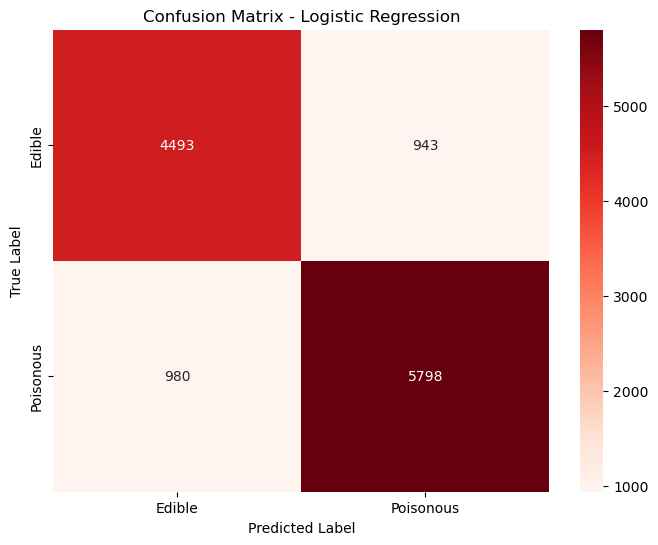

In [25]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [24]:
print("\nConfusion Matrix Analysis:")
print(f"True Negatives (Edible correctly classified): {cm[0,0]}")
print(f"False Positives (Edible wrongly classified as Poisonous): {cm[0,1]}")
print(f"False Negatives (Poisonous wrongly classified as Edible): {cm[1,0]}  DANGEROUS!")
print(f"True Positives (Poisonous correctly classified): {cm[1,1]}")


Confusion Matrix Analysis:
True Negatives (Edible correctly classified): 4493
False Positives (Edible wrongly classified as Poisonous): 943
False Negatives (Poisonous wrongly classified as Edible): 980  DANGEROUS!
True Positives (Poisonous correctly classified): 5798


### Performance Metrics explanation

#### Why Recall is Most Important for Mushroom Classification

For mushroom classification, **Recall (Sensitivity)** for the poisonous class is the **most critical metric** because:

1. **False Negatives are Dangerous**: Classifying a poisonous mushroom as edible could be **fatal**. This is far worse than the reverse error.
2. **Cost Asymmetry**: A False Positive (edible classified as poisonous) only means missing a meal, but a False Negative (poisonous classified as edible) could mean death.
3. **Safety-First Approach**: We want to catch as many poisonous mushrooms as possible, even if it means being overly cautious.

From the test set results:

**Accuracy (84.26%)**: Overall correctness, but doesn't capture the danger of false negatives.

**Precision for Poisonous (86%)**: When we predict a mushroom is poisonous, we're correct 86% of the time. High precision means fewer false alarms.

**Recall for Poisonous (86%)**: We correctly identify 86% of all poisonous mushrooms. This means **14% of poisonous mushrooms are misclassified as edible** - this is concerning!

**F1-Score (0.86)**: Harmonic mean of precision and recall, providing a balanced measure.

### Interpretation

- Our model achieves **86% recall** for poisonous mushrooms, meaning it catches most dangerous mushrooms
- However, the **14% false negative rate** is still risky in a real-world scenario
- For a real system, we might want to:
  - Lower the classification threshold to increase recall (catch more poisonous mushrooms)
  - Accept more false positives (classify more as poisonous) to minimize danger
  - Aim for **recall > 95%** for the poisonous class

In [26]:
## Validation Methodology 2: Train-Validation-Test Split

from sklearn.model_selection import train_test_split

# First split: separate test set (20%)
X_trainval, X_test_split, y_trainval, y_test_split = train_test_split(
    X_onehot, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Second split: separate validation set from training (20% of remaining 80% = 16% of total)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

scaler_split = StandardScaler()
X_train_split_scaled = scaler_split.fit_transform(X_train_split)
X_val_scaled = scaler_split.transform(X_val)
X_test_split_scaled = scaler_split.transform(X_test_split)

In [ ]:
log_reg_manual = LogisticRegression(random_state=42, max_iter=1000)

C_values = [0.001, 0.01, 0.1, 1, 10, 50 100]
val_scores = []

for C in C_values:
    log_reg_manual.set_params(C=C, penalty='l2')
    log_reg_manual.fit(X_train_split_scaled, y_train_split)
    val_score = log_reg_manual.score(X_val_scaled, y_val)
    val_scores.append(val_score)
    print(f"C={C}: Validation accuracy = {val_score:.4f}")

# Find best C
best_C = C_values[val_scores.index(max(val_scores))]

final_log_reg = LogisticRegression(random_state=42, max_iter=1000, solver='saga', C=best_C, penalty='l2')
final_log_reg.fit(X_train_split_scaled, y_train_split)

train_score = final_log_reg.score(X_train_split_scaled, y_train_split)
val_score = final_log_reg.score(X_val_scaled, y_val)
test_score = final_log_reg.score(X_test_split_scaled, y_test_split)

print(f"\nFinal Model Performance:")
print(f"Training accuracy: {train_score:.4f}")
print(f"Validation accuracy: {val_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

y_pred_final = final_log_reg.predict(X_test_split_scaled)
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_split, y_pred_final, target_names=['Edible', 'Poisonous']))

C=0.001: Validation accuracy = 0.8413
C=0.01: Validation accuracy = 0.8460
C=0.1: Validation accuracy = 0.8449
C=1: Validation accuracy = 0.8448
C=10: Validation accuracy = 0.8443
C=100: Validation accuracy = 0.8446

Final Model Performance:
Training accuracy: 0.8459
Validation accuracy: 0.8460
Test accuracy: 0.8493

=== Test Set Classification Report ===
              precision    recall  f1-score   support

      Edible       0.83      0.84      0.83      5436
   Poisonous       0.87      0.86      0.86      6778

    accuracy                           0.85     12214
   macro avg       0.85      0.85      0.85     12214
weighted avg       0.85      0.85      0.85     12214



Exception ignored in: <function ResourceTracker.__del__ at 0x10c63db20>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102965b20>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10d5adb20>
Traceback (most recent call last

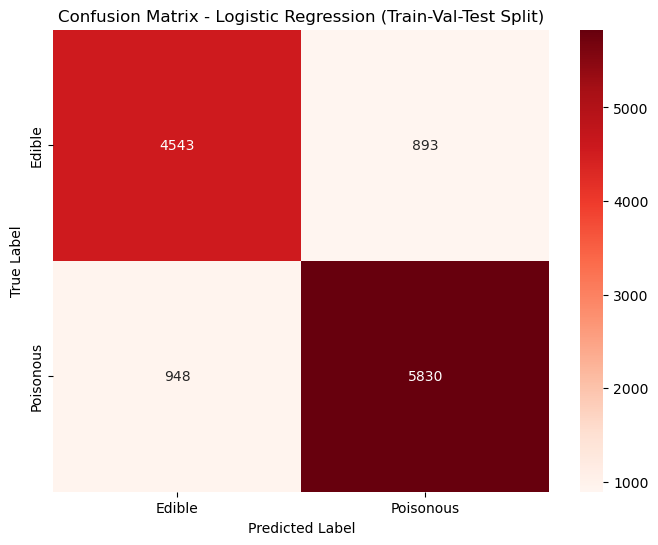

In [30]:
cm_split = confusion_matrix(y_test_split, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_split, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Edible', 'Poisonous'], 
            yticklabels=['Edible', 'Poisonous'])
plt.title('Confusion Matrix - Logistic Regression (Train-Val-Test Split)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
print("\nConfusion Matrix Analysis (Train-Val-Test Split):")
print(f"True Negatives (Edible correctly classified): {cm_split[0,0]}")
print(f"False Positives (Edible wrongly classified as Poisonous): {cm_split[0,1]}")
print(f"False Negatives (Poisonous wrongly classified as Edible): {cm_split[1,0]}  DANGEROUS!")
print(f"True Positives (Poisonous correctly classified): {cm_split[1,1]}")


Confusion Matrix Analysis (Train-Val-Test Split):
True Negatives (Edible correctly classified): 4543
False Positives (Edible wrongly classified as Poisonous): 893
False Negatives (Poisonous wrongly classified as Edible): 948  DANGEROUS!
True Positives (Poisonous correctly classified): 5830
